# 0. Setup.

In [124]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import nbimporter
import libs

# Rand seed.
import tensorflow as tf
tf.keras.utils.set_random_seed(42) # np, tf, python at once.  

# Set device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Suppress findfont warnings for Korean font, NanumGothic.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="findfont: *")

# Set Korean font for pyplot.
import matplotlib.font_manager as fm
font_path = r'C:\Users\yana\AppData\Local\Microsoft\Windows\Fonts\NanumGothic-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [2]:
%%html
<style>
    table {
        float: left;
        margin-right: 20px; /* Optional: Adds space between table and other content */
    }
</style>

# 1. Data Preparation.
- **Hennessy Order List**.
  - `./data/20250121_Hennessy_Clustering_20250120_BSH.csv`.
  - Order list of the company 'Hennessy' in 2024.
  - Ordered by `'DocDate'`.
  - **Size**: 13,528 samples (orders).
- **AlgoLab Order List**.
  - `./data/20250122_Order_List_202411_12_CJW.csv`.
  - Order list of AlgoLab in 2024.11 ~ 2024.12.
  - Postprocessed by AlgoLab backend, including geometric allocation with GIS.
  - Ordered by `'created'`.
  - **Size**: 44,619 samples (orders).

| Field                | Description                                              | Type         |
|----------------------|----------------------------------------------------------|--------------|
| `date`              | Date to order.                                           | *str: YYYY-MM-DD* |
| `customer_name`     | Name of the customer company, in Korean.                 | *str*        |
| `customer_address`  | Lot number address of the customer company, in Korean.   | *str*        |
| `address_latitude`  | Latitude of `customer_address`.                          | *float*      |
| `address_longitude` | Longitude of `customer_address`.                         | *float*      |
| `num_box_per_des`   | Number of boxes per each arrival destination.            | *int*        |


| Field                        | Description                                                                                     | Type                                                      |
|------------------------------|-------------------------------------------------------------------------------------------------|-----------------------------------------------------------|
| `name`                      | Name of the customer company, in Korean.                                                       | *str*                                                    |
| `created`                   | Datetime when the order is placed.                                                             | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `client_name`               | Name of client.                                                                                | *str*                                                    |
| `client_department`         | Department of the client.                                                                      | *str*                                                    |
| `sender_name`               | Name of client company.                                                                        | *str*                                                    |
| `sender_address`            | Lot number address of the customer company, in Korean.                                         | *str*                                                    |
| `sender_jibun_address`      | Lot number address (road number address).                                                      | *str*                                                    |
| `sender_latitude`           | Latitude of the sender's address, divided by 360,000.                                          | *int*                                                    |
| `sender_longitude`          | Longitude of the sender's address, divided by 360,000.                                         | *int*                                                    |
| `receiver_name`             | Name of the receiver's company.                                                               | *str*                                                    |
| `receiver_address`          | Lot number address of the receiver company, in Korean.                                         | *str*                                                    |
| `receiver_jibun_address`    | Lot number address (road number address) of the receiver.                                      | *str*                                                    |
| `receiver_latitude`         | Latitude of the receiver's address, divided by 360,000.                                        | *int*                                                    |
| `receiver_longitude`        | Longitude of the receiver's address, divided by 360,000.                                       | *int*                                                    |
| `aq_pickup_request_time`    | Datetime for due time of order. ***Need to check.***                                           | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `consignment`               | Items to be delivered. ***Format of dict is not strictly specified.***                        | *dict: {'category': {'name': str, 'description': str, 'quantity': 1}}* |
| `express`                   | Indicates if the order is express.                                                             | *bool*                                                   |
| `vehicle_type`              | Vehicle type for delivery.                                                                     | *str: {MOTORCYCLE, DAMAS, TRUCK, ...}*                   |
| `vehicle_option`            | Descriptive comment (e.g., 1T/CARGO).                                                          | *str*                                                    |
| `trip`                      | Indicates if delivery is one-way or round trip.                                                | *str: {ONE_WAY, ROUND_TRIP}*                             |
| `memo`                      | Written by AlgoLab's operator, possibly containing batch information.                          | *str*                                                    |
| `note`                      | Written by the customer.                                                                       | *str*                                                    |
| `status`                    | Order status.                                                                                  | *str: {'COMPLETE', 'CANCELLATION'}*                      |
| `rider_name`                | Name of the rider.                                                                             | *str*                                                    |
| `route`                     | Datetime/latitude/longitude stamps in arbitrary frequency during delivery.                     | *list: [dict: {'datetime': str, 'latitude': int, 'longitude': int}]* |
| `location_charge`           | ?                                                                                              | *int*                                                    |
| `extra_charge`              | ?                                                                                              | *int*                                                    |
| `allocated`                 | Datetime when the order is allocated.                                                          | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `before_picked_up`          | Datetime before the order is picked up.                                                        | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `picked_up`                 | Datetime when the order is picked up.                                                          | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `before_completed`          | Datetime before the order is completed.                                                        | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `completed`                 | Datetime when the order is completed.                                                          | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `canceled`                  | Datetime when the order is canceled.                                                           | *str: YYYY-MM-DD HH:mm:SS.sss*                           |
| `call24_order_number`       | ?                                                                                              | *int*                                                    |
| `distance`                  | ?                                                                                              | *float*                                                  |
| `isd_distance`              | ?                                                                                              | *float*                                                  |
| `assigned_charge`           | ?                                                                                              | *int*                                                    |
| `costcenter`                | ?                                                                                              | *str*                                                    |
| `*_charge`                  | Charges by type.                                                                               | Varies                                                  |


## 1.1. Load.

In [3]:
df_hennessy = pd.read_csv('./data/20250121_Hennessy_Clustering_20250120_BSH.csv', encoding='cp949')   # commonly used for Korean.
df_algolab  = pd.read_csv('./data/20250122_Order_List_202411_12_CJW.csv', encoding='cp949')

C:\Users\yana\AppData\Local\Temp\ipykernel_6580\4192077377.py:2: DtypeWarning: Columns (9,35,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_algolab  = pd.read_csv('./data/20250122_Order_List_202411_12_CJW.csv', encoding='cp949')


## 1.2. Column Rename.

In [4]:
# df_hennessy.
cols_rename = {
    'DocDate': 'date',
    'Customer Name': 'customer_name',
    '지번주소표준화': 'address_loc',
    '위도(latitude)': 'latitude',
    '경도(longitude)': 'longitude',
    '배송지별 BOX': 'n_boxes',
    '배송지수': 'n_destinations'
}

df_hennessy = df_hennessy.rename(columns=cols_rename)

# df_algolab. (tbd)

## 1.2. Null Check.

In [5]:
# Hennessy.
df_hennessy.info()
df_hennessy = df_hennessy.drop(columns=['n_destinations'])   # Fine, just delete the col '배송지수'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13528 entries, 0 to 13527
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            13528 non-null  object 
 1   customer_name   13528 non-null  object 
 2   address_loc     13528 non-null  object 
 3   latitude        13528 non-null  float64
 4   longitude       13528 non-null  float64
 5   n_boxes         13528 non-null  int64  
 6   n_destinations  0 non-null      float64
dtypes: float64(3), int64(1), object(3)
memory usage: 739.9+ KB


In [6]:
# AlgoLab.
df_algolab.info()

# Significant and unbalanced imputation needed. Let's check again before training.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44619 entries, 0 to 44618
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       44619 non-null  object 
 1   created                    44619 non-null  object 
 2   id                         44619 non-null  object 
 3   channel                    44619 non-null  object 
 4   isd_order_number           44454 non-null  float64
 5   client_name                44516 non-null  object 
 6   client_phone_number        44619 non-null  int64  
 7   client_department          36986 non-null  object 
 8   sender_name                44050 non-null  object 
 9   sender_phone_number        44619 non-null  object 
 10  sender_address             44619 non-null  object 
 11  sender_jibun_address       44619 non-null  object 
 12  sender_address_detail      37853 non-null  object 
 13  sender_bcode               44619 non-null  int

# 2. EDA (with Hennesy).
- To plot map: `!pip install basemap basemap-data-hires`.

In [7]:
# copy.
df = df_hennessy.copy()

### 2.1. Entire Orders.

In [8]:
from mpl_toolkits.basemap import Basemap

In [9]:
from mpl_toolkits.basemap import Basemap

# `create_map`: Create map with focusing on a specified city and zoom ratio.
def create_map(city, zoom_ratio=0.8):
    """
    Description: Creates a Basemap instance for visualizing different regions of South Korea.
    Args:
        city        = str, the region to focus on. ['entire', 'seoul', 'busan', 'daejeon'].
        zoom_ratio  = float, factor to zoom in or out. Default is 1.0 (original focus).
                     Values > 1.0 zoom out, values < 1.0 zoom in.
    Returns: 
        m = Basemap instance, configured for the specified region.
    """
    # Define the base coordinates for each city
    coordinates = {
        'Korea': (34.0, 38.5, 125.5, 130.0),
        'Seoul': (36.5, 38.5, 126.5, 128.0),
        'Busan': (34.0, 36.0, 127.5, 129.5),
        'Daejeon': (35.5, 37.0, 126.5, 128.5)
    }
    
    if city not in coordinates:
        raise ValueError("Invalid city. Valid options are 'entire', 'seoul', 'busan', or 'daejeon'.")

    # Get base coordinates
    llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon = coordinates[city]
    
    # Adjust boundaries based on zoom ratio
    lat_center = (llcrnrlat + urcrnrlat) / 2
    lon_center = (llcrnrlon + urcrnrlon) / 2
    lat_span = (urcrnrlat - llcrnrlat) / zoom_ratio
    lon_span = (urcrnrlon - llcrnrlon) / zoom_ratio

    # Recalculate corners
    llcrnrlat = lat_center - lat_span / 2
    urcrnrlat = lat_center + lat_span / 2
    llcrnrlon = lon_center - lon_span / 2
    urcrnrlon = lon_center + lon_span / 2

    # Create the Basemap instance
    m = Basemap(
        projection='merc',
        llcrnrlat=llcrnrlat,
        urcrnrlat=urcrnrlat,
        llcrnrlon=llcrnrlon,
        urcrnrlon=urcrnrlon,
        resolution='i'
    )

    return m

In [242]:
def plot_orders(df, city='Korea', zoom_ratio=1.0, is_main_cities=True, color_by_cluster=False, 
                figsize=(15,8), title="No Title", cmap='viridis'):
    """
    Description: Simple method to plot orders on a Korean map with optional clustering visualization.
    Args:
        df                = pd.DataFrame, where df['longitude'] and df['latitude'] are set.
        city              = city to focus. ['Korea', 'Seoul', 'Busan', 'Daejeon'].
        zoom_ratio        = float, zoom level for the map. Default is 1.0.
        is_main_cities    = if 'True', draws some main cities. ONLY works when `city`='Korea'.
        color_by_cluster  = if 'True', colors points by cluster (k-means or hierarchical).
        figsize           = (x, y). figsize for pyplot.
        title             = str to specify title of the plot.
        cmap              = str, colormap to use.
    Returns: None.
    """
    
    # Map size
    plt.figure(figsize=figsize)
    
    # Create a Basemap instance focused on the specified city
    m = create_map(city, zoom_ratio=zoom_ratio)
    
    # Draw map boundaries, coastlines, and country borders
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgreen', lake_color='lightblue')
    
    # Plot main cities (if applicable)
    if is_main_cities and city == 'Korea':
        city_data = [
            ("Seoul", 37.5665, 126.9780),   # Seoul
            ("Busan", 35.1796, 129.0756),   # Busan
            ("Daejeon", 36.3504, 127.3845)  # Daejeon
        ]
        for city_name, lat, lon in city_data:
            xx, yy = m(lon, lat)  # Convert latitude and longitude to map coordinates
            plt.text(xx - 50000, yy, city_name, fontsize=12, ha='right', color='black')  # Adjust text position
            m.scatter(xx, yy, marker='x', color='blue', zorder=5, s=100)  # Blue X marker
    
    # Convert latitude and longitude to map coordinates
    x, y = m(df['longitude'].values, df['latitude'].values)
    
    # Plot orders or clusters
    if color_by_cluster:
        cluster_labels = df['cluster']
        
        # Normalize cluster labels to ensure colorbar scaling is correct
        scatter = m.scatter(
            x, y,
            c=cluster_labels,
            cmap=cmap,
            s=10,
            alpha=0.7,
            zorder=5,
            vmin=cluster_labels.min(),  # Set minimum value for the colorbar
            vmax=cluster_labels.max()   # Set maximum value for the colorbar
        )
        plt.colorbar(scatter, label='Cluster')
    else:
        # Default red color for orders
        m.scatter(x, y, marker='o', color='red', zorder=5, s=10)
    
    # Title and display the plot
    plt.title(title + f' (City: {city})')
    plt.show()


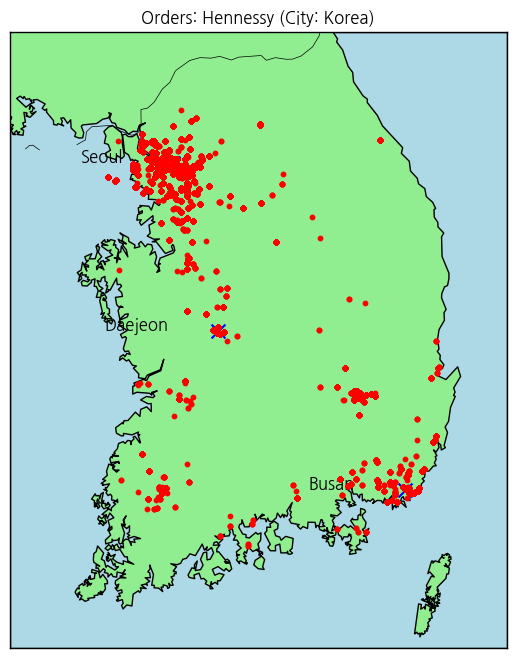

In [84]:
# Plot entire orders.
plot_orders(df, zoom_ratio=1.0, city='Korea')

### 2.2. By City.

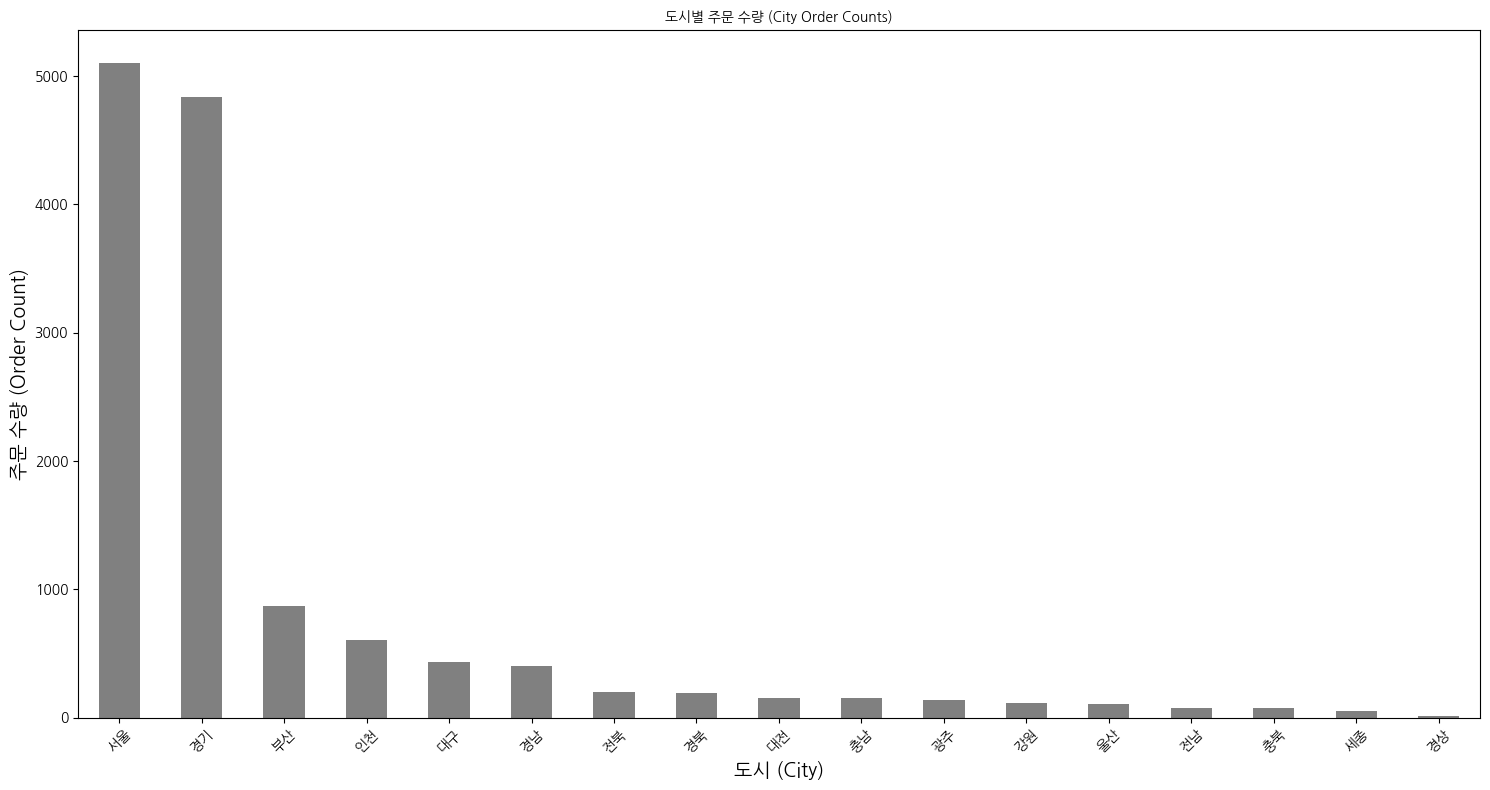

In [21]:
# Histogram for each city
city_counts = df['city'].value_counts()

# Plot a bar chart
plt.figure(figsize=(15, 8))
city_counts.plot(kind='bar', color='grey')

# Add title and labels (with the Korean font)
plt.title('도시별 주문 수량 (City Order Counts)', fontsize=16, fontproperties=font_prop)
plt.xlabel('도시 (City)', fontsize=14, fontproperties=font_prop)
plt.ylabel('주문 수량 (Order Count)', fontsize=14, fontproperties=font_prop)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, fontproperties=font_prop)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [55]:
# Share of Seoul and Gyeonggi.
seoul_gyeonggi_count = df[df['city'].isin(['서울', '경기'])].shape[0]
total_count = df.shape[0]
share = (seoul_gyeonggi_count / total_count) * 100
print(f"Share of Seoul and Gyeonggi: {share:.2f}%")

Share of Seoul and Gyeonggi: 73.46%


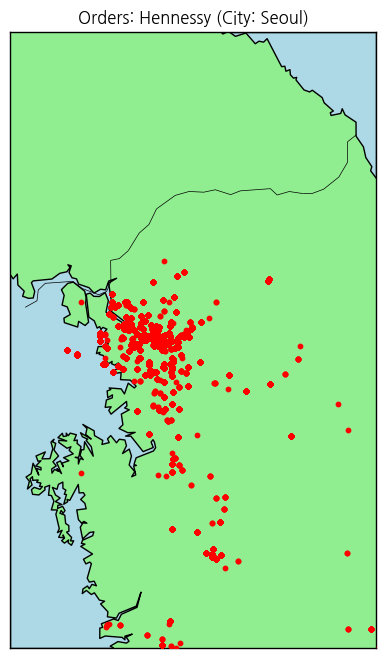

In [12]:
# Plot Seoul.
plot_orders(df, zoom_ratio=0.6, city='Seoul')

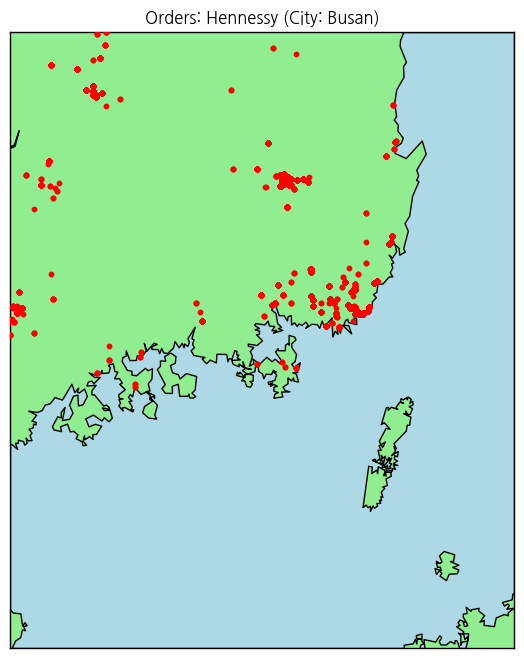

In [13]:
# Plot Busan.
plot_orders(df, zoom_ratio=0.6, city='Busan')

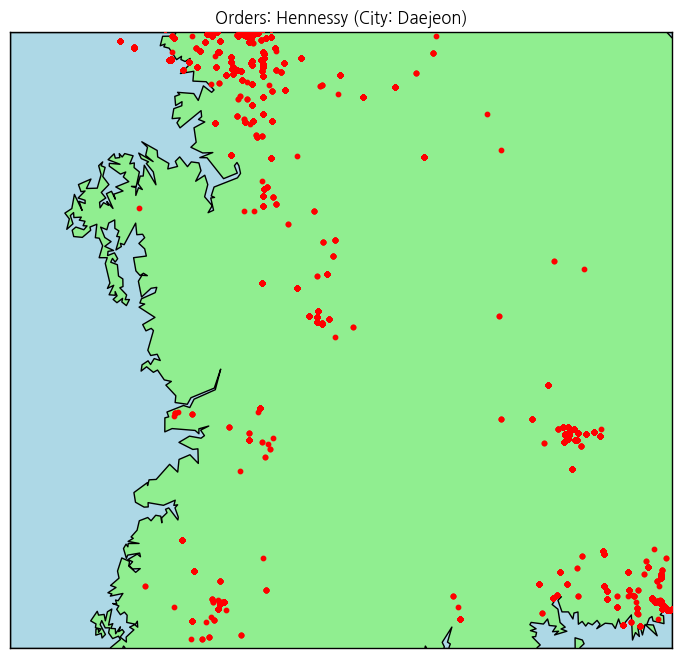

In [14]:
# Plot Daejeon.
plot_orders(df, zoom_ratio=0.6, city='Daejeon')

### 2.3. By Month.

In [15]:
# `plot_orders_by_month`: plot orders by month into the Korean map, creating subplots for each month.
def plot_orders_by_month(df, city='Korea', zoom_ratio=1.0, is_main_cities=True):
    """
    Description: Create subplots to plot orders for each month in Korean map.
    Args:
        df              = pd.DataFrame, where df['longitude'], df['latitude'], and df['date'] are set.
        city            = city to focus. ['Korea', 'Seoul', 'Busan', 'Daejeon']
        is_main_cities  = if 'True', draws some main cities. ONLY works when `city`='Korea'.
    Returns: None.
    """
    
    # Convert the 'date' column to datetime format and extract month.
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month

    # Create a sorted list of unique months in the data.
    months = sorted(df['month'].unique())
    n_months = len(months)

    # Create subplots with 4 columns per row.
    n_cols = 4
    n_rows = -(-n_months // n_cols)  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, month in enumerate(months):
        # Filter data for the current month.
        month_df = df[df['month'] == month]

        # Create a Basemap instance for the specified city.
        m = create_map(city, zoom_ratio=zoom_ratio)

        # Draw map boundaries, coastlines, and country borders.
        m.drawcoastlines(ax=axes[i])
        m.drawcountries(ax=axes[i])
        m.drawmapboundary(fill_color='lightblue', ax=axes[i])
        m.fillcontinents(color='lightgreen', lake_color='lightblue', ax=axes[i])

        # Plot some main cities if enabled and city is 'Korea'.
        if is_main_cities and city == 'Korea':
            city_data = [
                ("Seoul", 37.5665, 126.9780),   # Seoul
                ("Busan", 35.1796, 129.0756),   # Busan
                ("Daejeon", 36.3504, 127.3845)  # Daejeon
            ]
            for c, lat, lon in city_data:
                xx, yy = m(lon, lat)
                axes[i].text(xx - 50000, yy, c, fontsize=10, ha='right', color='black')
                m.scatter(xx, yy, marker='x', color='blue', zorder=5, s=50, ax=axes[i])

        # Plot orders for the current month.
        x, y = m(month_df['longitude'].values, month_df['latitude'].values)
        m.scatter(x, y, marker='o', color='red', zorder=5, s=10, ax=axes[i])

        # Set the title for the subplot.
        axes[i].set_title(f'Orders in Month: {month} (City: {city})')

    # Turn off unused axes.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

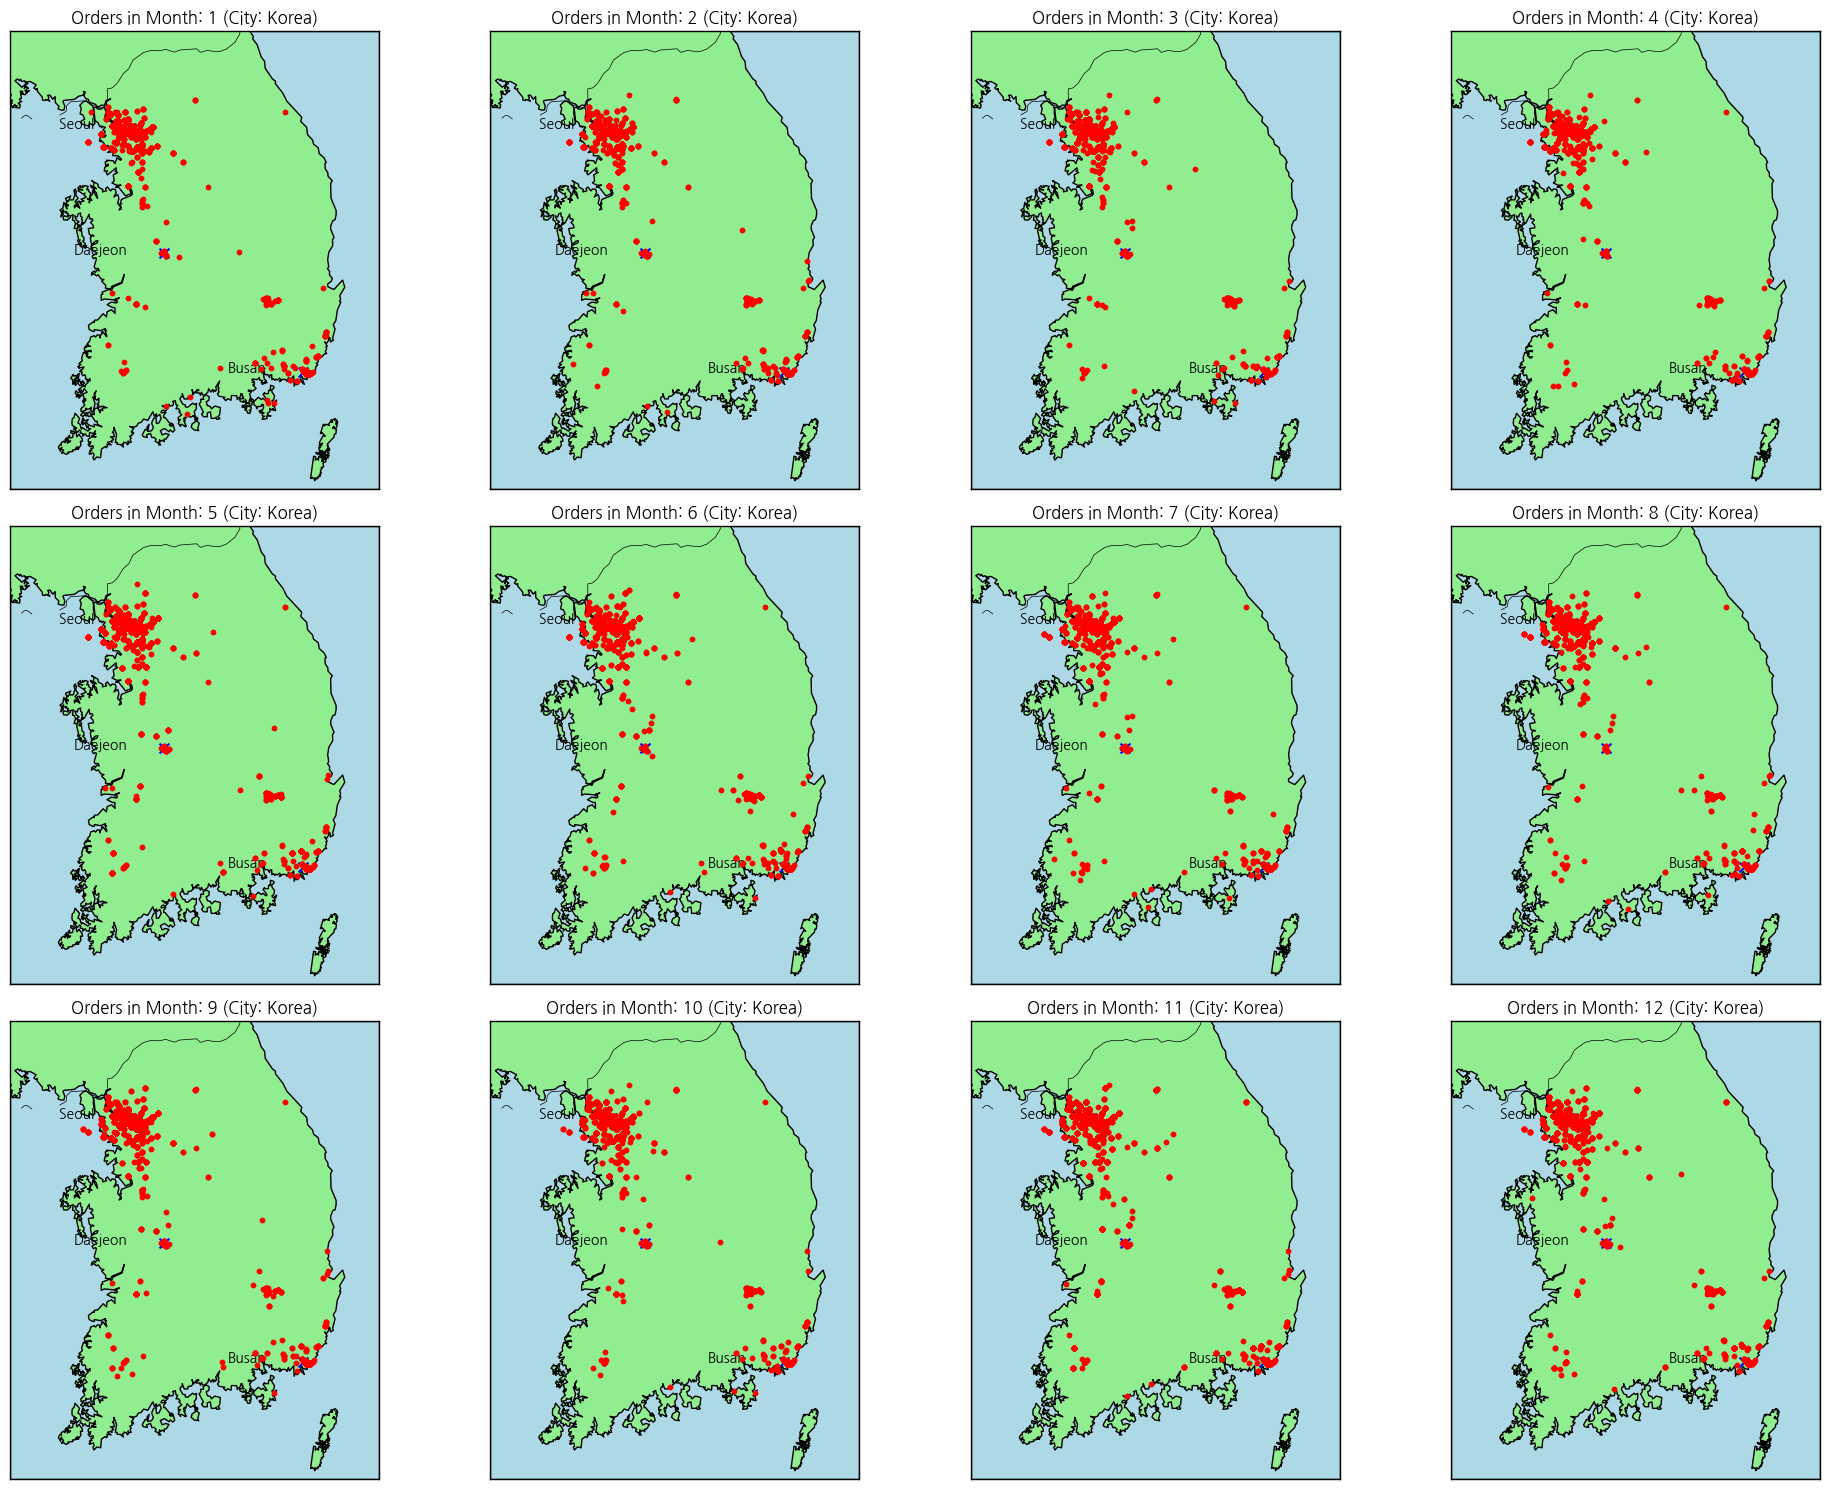

In [16]:
plot_orders_by_month(df)

In [17]:
# Assuming df['date'] contains the date information
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is in datetime format
df['month'] = df['date'].dt.month       # Extract the month

# Group the DataFrame by month
monthly_dfs = {month: group for month, group in df.groupby('month')}

# Now, monthly_dfs is a dictionary where keys are months (1 to 12) and values are DataFrames
# Example to check the data for January:
january_df = monthly_dfs[1]  # Data for January


### 2.4. Boxplot.

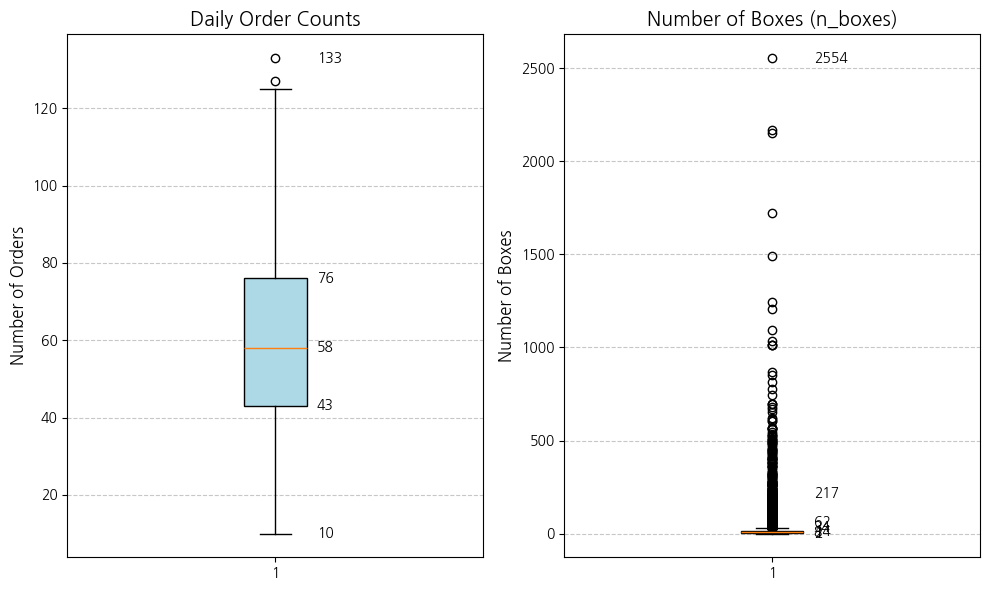

Quantiles of n_orders:
0.00     10.0
0.25     43.0
0.50     58.0
0.75     76.0
1.00    133.0
dtype: float64

Quantiles of n_boxes:
0.00       1.00
0.25       2.00
0.50       8.00
0.75      14.00
0.90      34.00
0.95      62.00
0.99     217.19
1.00    2554.00
Name: n_boxes, dtype: float64


In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Count the number of samples (orders) for each day
daily_counts = df.groupby('date').size()

# Quantiles for daily order counts
daily_counts_quantiles = daily_counts.quantile([0, 0.25, 0.5, 0.75, 1.0])

# Quantiles for raw `n_boxes`
n_boxes_quantiles = df['n_boxes'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Boxplot for daily order counts
axes[0].boxplot(daily_counts, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[0].set_title('Daily Order Counts', fontsize=14)
axes[0].set_ylabel('Number of Orders', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate quantiles for daily order counts
for q in daily_counts_quantiles:
    axes[0].text(1.1, q, f"{int(q)}", fontsize=10, va='center')

# Boxplot for raw `n_boxes`
axes[1].boxplot(df['n_boxes'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[1].set_title('Number of Boxes (n_boxes)', fontsize=14)
axes[1].set_ylabel('Number of Boxes', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Annotate quantiles for `n_boxes`
for q in n_boxes_quantiles:
    axes[1].text(1.1, q, f"{int(q)}", fontsize=10, va='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print(f'Quantiles of n_orders:')
print(daily_counts_quantiles)
print()
print(f'Quantiles of n_boxes:')
print(n_boxes_quantiles)

## 2.5. Summary.
- One of most important feature `city`, has highly imbalanced distribution.
  - **'Seoul'** and **'Gyeonggi'** takes 73.46%.
  - Last of orders clearly do not have uniform or Gaussian distribution in geometrically aspects.
  - Clustering should support uneven size and shape, not regular convex one.
- Extensive range of num_boxes:
  - 95% are < 62, though 100% is 2,554.
  - Considering the transportation capability of the truck, these outliers should be excluded first, from batching.
- Number of daily orders seems under normal distribution:
  - Clustering by day will show stable and robust result accross days.
  - If there is strong evidence of clustering based on geometric information, we can expect fixed ratio btw num of orders and num of clusters.
  - Which implies that the number of clusters should be specified dynamically.

# 3. Typical Unsupervised Models.

## 3.1. K-means.
- Limitation is clear: can't dynamically cluster in terms of size and shape.

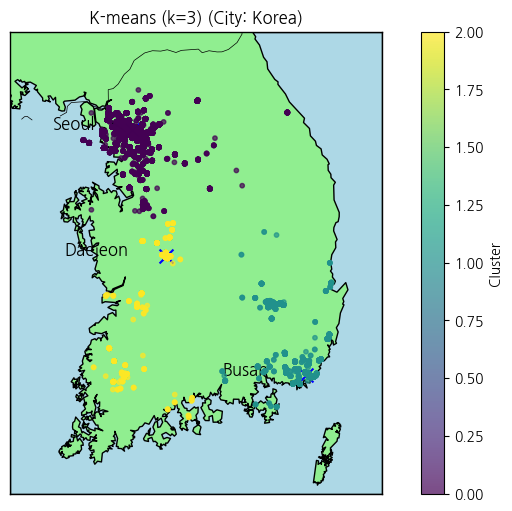

In [243]:
from sklearn.cluster import KMeans

coords = df[['latitude', 'longitude']]

# k = 3.
k = 3
kmeans = KMeans(n_clusters=k)  
df['cluster'] = kmeans.fit_predict(coords)

plot_orders(df, color_by_cluster=True, figsize=(10,6), title=f'K-means (k={k})')

C:\Users\yana\anaconda3\envs\algolab_rnd\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


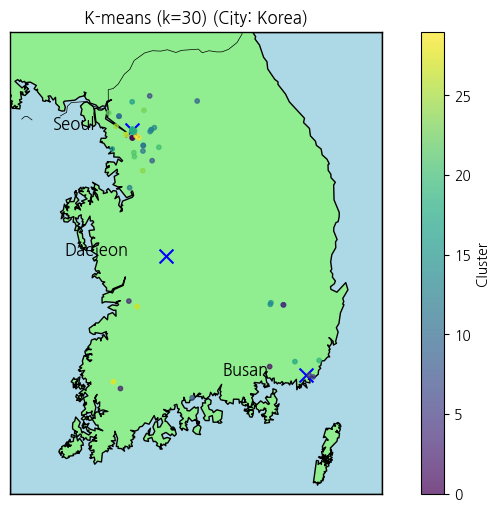

In [244]:
# k = 30, n_samples = 50.
sample_df = df.sample(n=50, random_state=42)
coords = sample_df[['latitude', 'longitude']]
k = 30
kmeans = KMeans(n_clusters=k)  
sample_df['cluster'] = kmeans.fit_predict(coords)

plot_orders(sample_df, color_by_cluster=True, figsize=(10,6), title=f'K-means (k={k})')

C:\Users\yana\anaconda3\envs\algolab_rnd\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


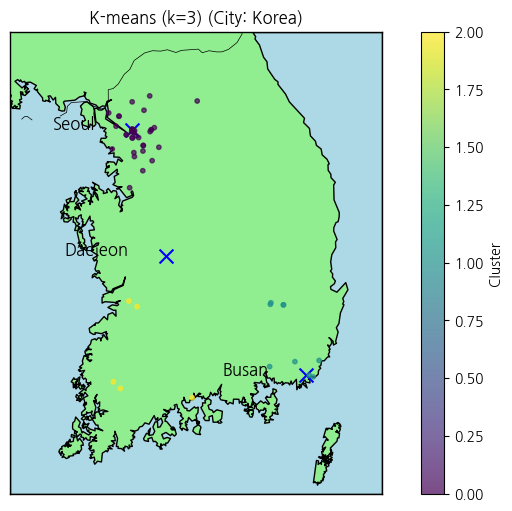

In [245]:
# k = 3, n_samples = 50.
sample_df = df.sample(n=50, random_state=42)
coords = sample_df[['latitude', 'longitude']]
k = 3
kmeans = KMeans(n_clusters=k)  
sample_df['cluster'] = kmeans.fit_predict(coords)

plot_orders(sample_df, color_by_cluster=True, figsize=(10,6), title=f'K-means (k={k})')

## 3.2. Affinity Propagation.

Number of Orders in 2024-01-10: 1000


C:\Users\yana\anaconda3\envs\algolab_rnd\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


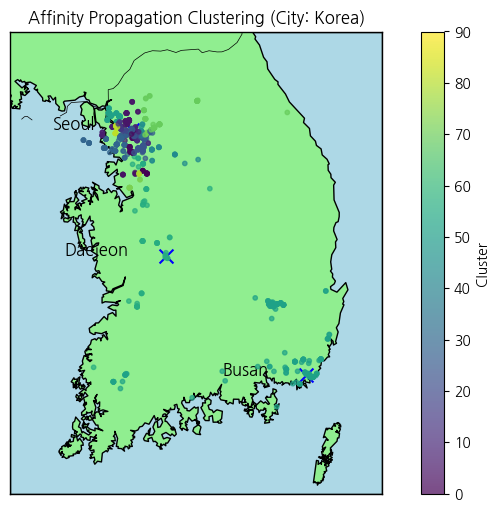

CPU times: total: 5.64 s
Wall time: 1.98 s


In [248]:
%%time
from sklearn.cluster import AffinityPropagation

# Extract latitude and longitude for clustering
sample_df = df.sample(n=1000, random_state=42)
coords = sample_df[['latitude', 'longitude']]

print(f'Number of Orders in {specific_date}: {len(sample_df)}')

# Perform Affinity Propagation
affinity = AffinityPropagation(
    damping=0.9,              # Damping factor (default: 0.5, range: 0.5 to 1.0)
    max_iter=100,             # Maximum number of iterations
    convergence_iter=50,      # Number of iterations with no change to converge
    preference=-1000,          # Preference for exemplars
    random_state=42,          # Seed for reproducibility
).fit(coords)

# Add cluster labels to the DataFrame
sample_df['cluster'] = affinity.predict(coords)

# Plot the clusters
plot_orders(sample_df, color_by_cluster=True, figsize=(10, 6), title='Affinity Propagation Clustering')

## 3.3. DBSCAN.

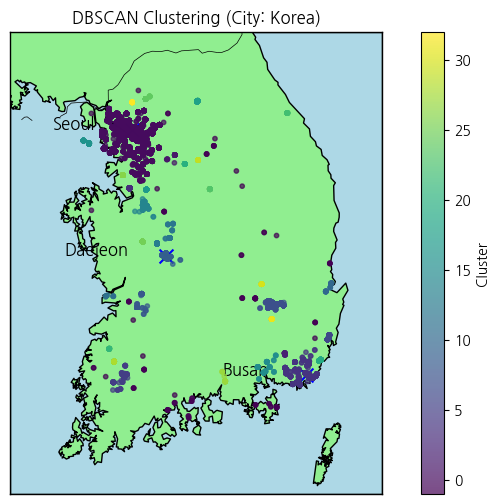

In [264]:
from sklearn.cluster import DBSCAN

# Extract latitude and longitude for clustering
sample_df = df.copy()
coords = sample_df[['latitude', 'longitude']]

dbscan = DBSCAN(eps=0.10, min_samples=10).fit(coords)  # Adjust `eps` for sensitivity
sample_df['cluster'] = dbscan.labels_

plot_orders(sample_df, color_by_cluster=True, figsize=(10, 6), title='DBSCAN Clustering')

## 3.4. AgglomerativeClustering.

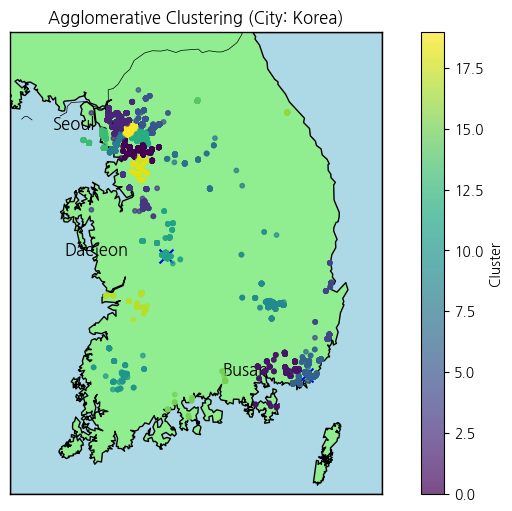

In [268]:
from sklearn.cluster import AgglomerativeClustering

# Sample data
sample_df = df.copy()

# Extract coordinates
coords = sample_df[['latitude', 'longitude']]

# Perform Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=20, distance_threshold=None)  # Adjust distance_threshold
sample_df['cluster'] = agglo.fit_predict(coords)

# Plot the clusters
plot_orders(sample_df, color_by_cluster=True, figsize=(10, 6), title='Agglomerative Clustering')


## 3.5. Dendrogram and fcluster.

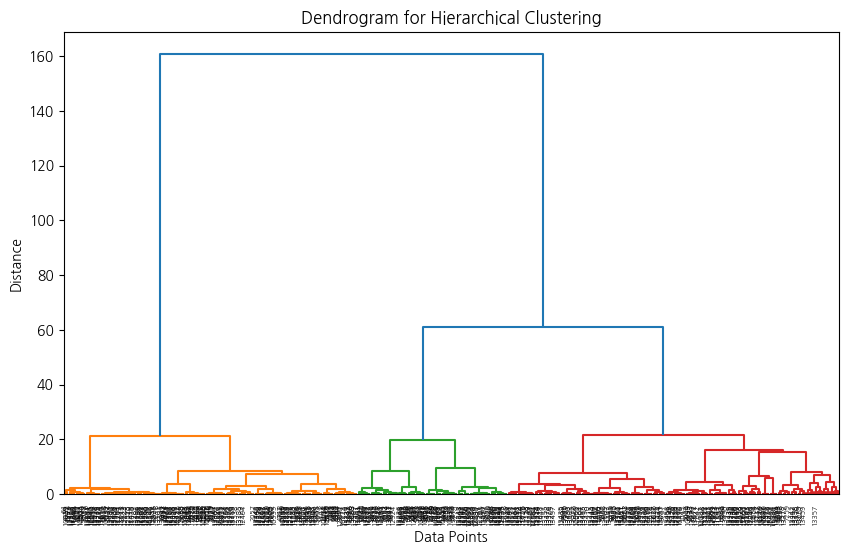

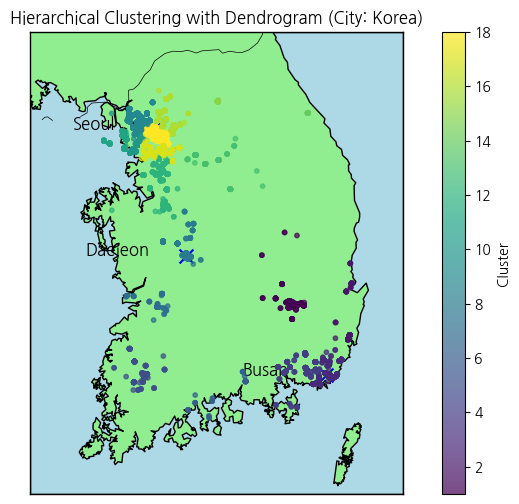

In [274]:
# On the Whole Data.
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import pandas as pd

sample_df = df.copy()
coords = sample_df[['latitude', 'longitude']]

# Perform hierarchical clustering
Z = linkage(coords, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode='level',  # Show up to a specific level in the hierarchy
    p=10,  # Number of levels to display in the dendrogram
    show_leaf_counts=False,  # Avoid showing individual data points
    color_threshold=50,  # Automatically color clusters at the current level
)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Extract clusters at different levels of the hierarchy
sample_df['cluster'] = fcluster(Z, t=5, criterion='distance')  # Adjust `t` for granularity

# Plot the clusters
plot_orders(
    sample_df,
    color_by_cluster=True,
    figsize=(10, 6),
    title='Hierarchical Clustering with Dendrogram',
    cmap='viridis'  
)


In [273]:
sample_df['cluster'].value_counts()

cluster
18    4233
9     2060
17    1306
3      960
16     883
12     860
10     770
1      598
11     442
8      310
4      301
5      219
7      180
13     146
2      137
15      68
6       38
14      17
Name: count, dtype: int64

Number of clusters formed: 19


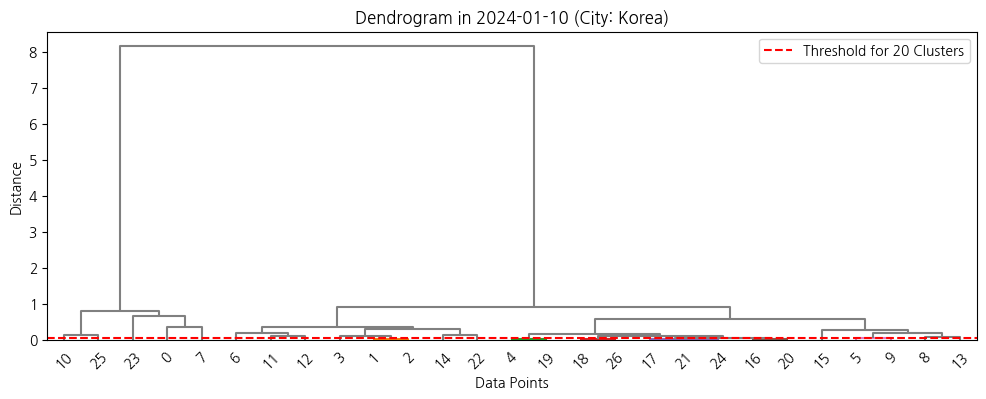

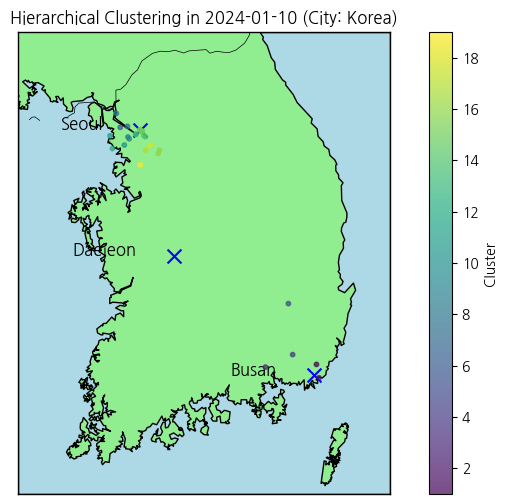

In [236]:
# On Sample Data, 1 day.
specific_date = '2024-01-10'
sample_df = df[df['date'] == specific_date].copy()
coords = sample_df[['latitude', 'longitude']]

# Perform hierarchical clustering
Z = linkage(coords, method='ward')  # Ward minimizes variance within clusters

# Dynamically calculate the distance threshold for 8 clusters
n_clusters = 20
distance_threshold = Z[-(n_clusters - 1), 2]  # Distance where n_clusters clusters form

# Force correct cluster extraction for comparison
sample_df['cluster'] = fcluster(Z, t=distance_threshold, criterion='distance')

# Verify the number of unique clusters
print(f"Number of clusters formed: {sample_df['cluster_hierarchical'].nunique()}")

# Plot the full dendrogram
plt.figure(figsize=(12, 4))
dendrogram(
    Z,
    color_threshold=distance_threshold,  # Ensure colors are applied at the correct distance
    above_threshold_color='grey',  # Color for merges above the threshold
)
plt.title(f"Dendrogram in {specific_date} (City: Korea)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=distance_threshold, c='red', linestyle='--', label=f'Threshold for {num_clusters} Clusters')
plt.legend()
plt.show()

# Plot the clusters
plot_orders(
    sample_df,
    color_by_cluster=True,
    figsize=(10, 6),
    title=f'Hierarchical Clustering in {specific_date}',
    cmap='viridis'  
)
